# The HSOM class
This tutorial will help you understand the core of **HySOM**, the `HSOM` class. You will learn the fundamental methods for training and exploring a trained SOM.
To demonstrate its functionality, we will use a sample dataset included with **HySOM**. More details on the `HSOM` class can be found in the [API reference](https://hysom.readthedocs.io/en/latest/api.html)


In [1]:
import numpy as np
from hysom import HSOM 
from hysom.utils.datasets import get_labeled_loops
import matplotlib.pyplot as plt


## Get sample data

The sample data consists of 340 labeled loops
Each loop is a matrix of shape: (100, 2)
Example: 


Text(0, 0.5, 'Normalized\nTurbidity')

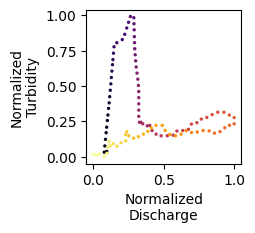

In [2]:
loops, labels = get_labeled_loops()

print(f"The sample data consists of {len(loops)} labeled loops")
print(f"Each loop is a matrix of shape: {loops[0].shape}")
print("Example: ")
sample_loop = loops[np.random.choice(len(loops))]
plt.figure(figsize=(2,2))
_ = plt.scatter(sample_loop[:,0],sample_loop[:,1], s = 2, cmap = "inferno", c = range(len(sample_loop)))
plt.xlabel("Normalized\nDischarge")
plt.ylabel("Normalized\nTurbidity")

## Training a SOM

Creating a new SOM instance requires three mandatory arguments to define the SOM's lattice dimensions and the input data dimensions: `width`, `height`and `input_dim`. Currently, only 2D sequences are supported, meaning the `input_dim` should follow the format: `(sequence_length,2)`.   
Additionally, you can specify an optional `random_seed` to ensure reproducibility


In [3]:
mysom = HSOM(width=5, height=5, input_dim = (100,2), random_seed=1234567)

Once instantiated, the `train` method can be called with two mandatory arguments: `data`, which is a sequence of training loops, and `epochs`, which defines the number of training iterations (each loop is fed to the map once per epoch). Several optional arguments provide full control over the training process, including `distance_function` (defaults to Dynamic Time Warping), `neighborhood_function` (defaults to Gaussian), `[initial/final]_learning_rate`, and more (see the [API reference](https://hysom.readthedocs.io/en/latest/api.html#hysom.hysom.HSOM.train)).  
In this tutorial, we will only include `track_errors` to record the history of the quantization and topographic errors during training and `verbose` to get reports of the training process in the console.


In [4]:
epochs = 5
mysom.train(data= loops, epochs = epochs, track_errors=True, verbose = 4)


Epoch: 1/5 - Quant. Error: 0.91 - Topo. Error: 0.65
[85/340] 25%
[170/340] 50%
[255/340] 75%
[340/340] 100%
Epoch: 2/5 - Quant. Error: 1.43 - Topo. Error: 0.0
[85/340] 25%
[170/340] 50%
[255/340] 75%
[340/340] 100%
Epoch: 3/5 - Quant. Error: 1.25 - Topo. Error: 0.0
[85/340] 25%
[170/340] 50%
[255/340] 75%
[340/340] 100%
Epoch: 4/5 - Quant. Error: 1.02 - Topo. Error: 0.0
[85/340] 25%
[170/340] 50%
[255/340] 75%
[340/340] 100%
Epoch: 5/5 - Quant. Error: 0.91 - Topo. Error: 0.0
[85/340] 25%
[170/340] 50%
[255/340] 75%
[340/340] 100%
Training Completed! - Quant. Error: 0.87 - Topo. Error: 0.0


The trained `prototypes` (also called *codebooks* or *weight vectors* in the SOM jargon) can be extracted using `get_prototypes()`

In [5]:
trained_prototypes = mysom.get_prototypes()

print(f"Prototypes are {type(trained_prototypes)} of shape: {trained_prototypes.shape}")


Prototypes are <class 'numpy.ndarray'> of shape: (5, 5, 100, 2)


## Visualize Prototypes
Checkout [This tutorial](https://hysom.readthedocs.io/en/latest/tutorials/vizfunctions.html) to explore the visualization functions in detail

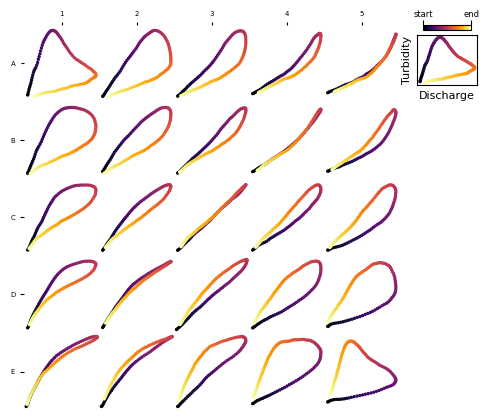

In [6]:
from hysom.utils.plots import plot_map

_ = plot_map(mysom.get_prototypes())

## Inspecting Quantization and Topographic Errors 

While quantization and topographic errors are displayed in the console after each epoch, the full history can be accessed using `get_QE_history` and `get_TE_history`. The QE and TE histories are useful to diagnose the training process

In [7]:
qe_iter_index, qe = mysom.get_QE_history()
te_iter_index, te  = mysom.get_TE_history()

Let's plot them!

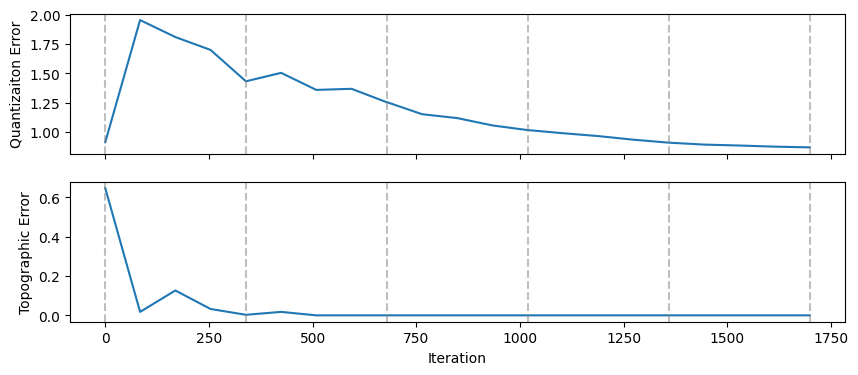

In [8]:
fig, (ax_qe, ax_te) = plt.subplots(2,1, figsize = (10,4), sharex=True)

# Plot topographic and quantization errors
ax_qe.plot(qe_iter_index, qe)
ax_te.plot(te_iter_index, te)
ax_qe.set_ylabel("Quantizaiton Error")
ax_te.set_xlabel("Iteration")
ax_te.set_ylabel("Topographic Error")

# Mark epochs
iterations_per_epoch = len(loops)
idx = 0
for i in range(epochs+1):
    ax_qe.axvline(idx, color = "grey", linestyle  = "--", alpha = 0.5)
    ax_te.axvline(idx, color = "grey", linestyle  = "--", alpha = 0.5)
    idx += iterations_per_epoch

Note that TE and QE are not computed after each iteration, as doing so would be computationally expensive. You can control how often errors are computed using the `errors_sampling_rate` argument of the `train` method. By default, this value is set to `4`, meaning errors are computed four times per epoch, plus an initial computation at the very beginning.


In [9]:
qe_iter_index[:5]

(0, 84, 169, 254, 339)

If you need to compute QE and TE for an arbitrary dataset using the final trained SOM, you can use the `quantization_error` and `topographic_error` methods (we'll use the same training data but other datasets, not used during training, can be used as well). These methods return the TE and QE for each sample in the provided dataset

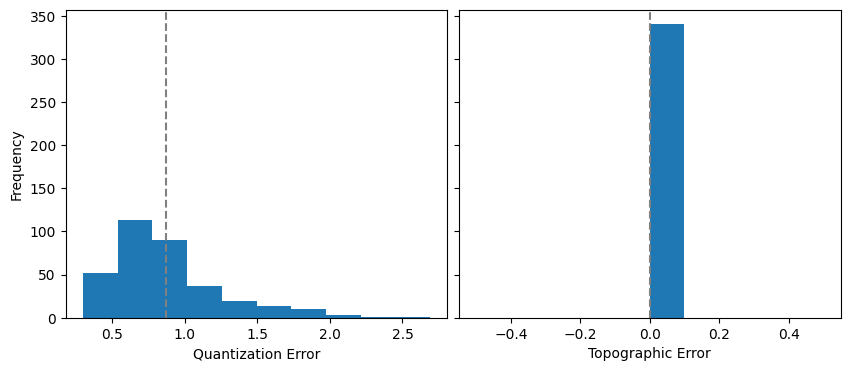

In [10]:
QE_final = mysom.quantization_error(loops)
TE_final = mysom.topographic_error(loops)

fig, (axqe, axte) = plt.subplots(1,2, sharey=True, figsize = (10,4))
axqe.hist(QE_final)
axte.hist(TE_final)
axqe.axvline(np.mean(QE_final), linestyle= "--", color = "grey")
axte.axvline(np.mean(TE_final), linestyle= "--", color = "grey")
axqe.set_ylabel("Frequency")
axqe.set_xlabel("Quantization Error")
axte.set_xlabel("Topographic Error")
plt.subplots_adjust(wspace=0.03)

## Classifying a new sample 

With a trined SOM, you can classify a sample using the `get_BMU` method.  
See [below](thesomclass.ipynb#classify-multiple-samples) how to efficiently classify multiple samples 

In [11]:
sample_idx = np.random.randint(0, len(loops))
sample = loops[sample_idx]
BMU = mysom.get_BMU(sample)
print(BMU)

(4, 1)


`get_BMU` returns the coordinates of the Best Matching Unit following matrix notation `(row, col)`. The associated prototype can be obtained using: `get_prototypes()[BMU]` 

In [12]:
matching_prototype = mysom.get_prototypes()[BMU]

Let's plot the sample and matching prototypes as trajectory plots

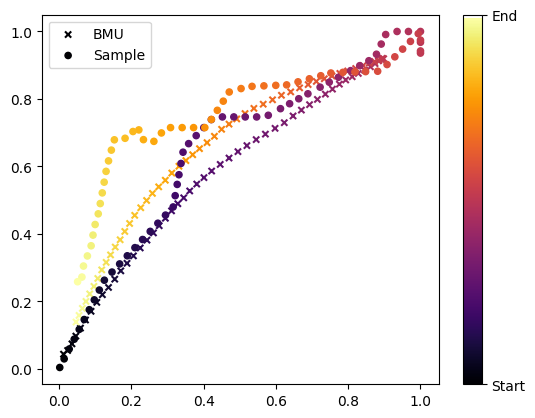

In [13]:
plt.figure()
plt.scatter(matching_prototype[:,0], matching_prototype[:,1], c = range(len(sample)), cmap = "inferno", s = 20, marker = "x", label = "BMU")
sc = plt.scatter(sample[:,0], sample[:,1], c = range(len(sample)), cmap = "inferno", s = 20, label = "Sample")

cb = plt.colorbar(sc)
cb.ax.set_yticks(ticks = [0, len(sample)], labels = ["Start", "End"])
plt.legend()

## Classify multiple samples

Use the `HSOM` method `classify` to group samples according to their BMU: 

In [14]:
classified_loops = mysom.classify(loops)

print("   BMU     # of loops")
for BMU, loops_list in classified_loops.items():
    print(f"{str(BMU):10s}    {len(loops_list)}")

   BMU     # of loops
(3, 2)        12
(2, 2)        26
(3, 1)        10
(2, 1)        9
(0, 4)        16
(0, 3)        11
(1, 3)        6
(1, 4)        12
(4, 0)        11
(4, 1)        15
(0, 2)        17
(0, 1)        8
(1, 0)        3
(1, 1)        15
(3, 0)        18
(2, 0)        18
(1, 2)        12
(3, 3)        14
(4, 3)        9
(3, 4)        9
(2, 3)        11
(2, 4)        19
(4, 2)        18
(4, 4)        21
(0, 0)        20


You can plot the loops associated to a BMU as follows:

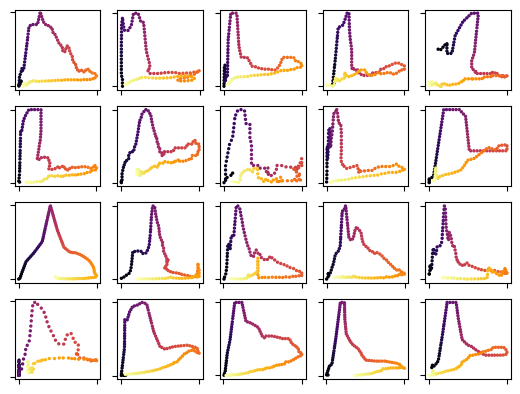

In [15]:
selected_bmu = (0,0)

fig = plt.figure()
for i, loop in enumerate(classified_loops[selected_bmu]):
    ax = fig.add_subplot(4,5,i+1)
    ax.scatter(loop[:,0], loop[:,1], cmap= "inferno", s = 2, c = range(len(loop)))
    ax.tick_params(labelbottom = False, labelleft = False)



Compare them with the associated prototype:

Text(0.5, 0.98, 'Trained SOM')

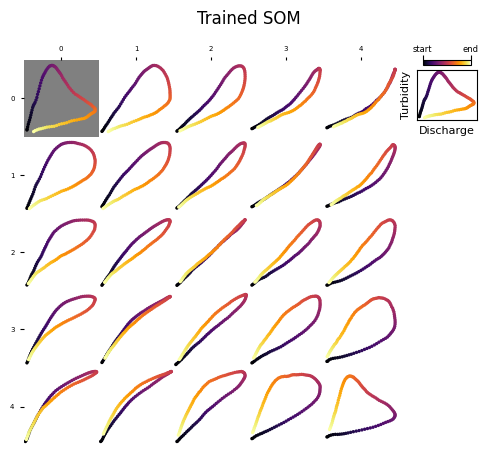

In [16]:
axs = plot_map(mysom.get_prototypes(), coordinates_style="matrix")
axs[selected_bmu].set_facecolor("gray")
axs[selected_bmu].figure.suptitle("Trained SOM")